In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [4]:
from langgraph.graph import MessagesState

In [5]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [7]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal['researcher', 'coder', 'FINISH']


llm = ChatOpenAI()


def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
    }


builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

In [35]:
from langgraph.checkpoint.memory import MemorySaver

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

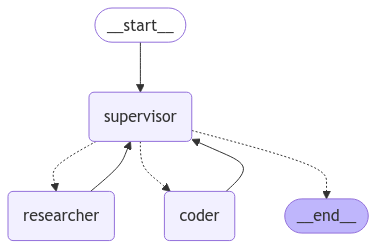

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
def run_graph(input: str, config: dict):
    for s in graph.stream(
        {"messages": [("user", input)]}, config, subgraphs=True
    ):
        data = s[1]
        if metadata := data.get('supervisor', ''):
            next = metadata['next']
            print(f'Próximo Node: {next}')
        elif metadata := data.get('agent', ''):
            message = metadata['messages'][-1].pretty_print()
            print(message)
        elif metadata := data.get('tools', ''):
            message = metadata['messages'][-1].pretty_print()
            print(message)
        elif metadata := data.get('researcher', ''):
            message = metadata['messages'][-1].pretty_print()
            print(message)
        # pprint(s)
        print("----"*20)

In [ ]:
thread_config = {"configurable": {"thread_id": "1"}}
run_graph("What's the square root of 42?", thread_config)

Próximo Node: researcher
--------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7tlTlIknFwUq1JBya3mN4o5t)
 Call ID: call_7tlTlIknFwUq1JBya3mN4o5t
  Args:
    query: 2 + 2
  tavily_search_results_json (call_26wPMAmP5O7UuybA9rqyjtbf)
 Call ID: call_26wPMAmP5O7UuybA9rqyjtbf
  Args:
    query: What is 2 plus 2?
None
--------------------------------------------------------------------------------
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.numerade.com/ask/question/what-is-2-plus-2-81313/", "content": "what is 2 plus 2. Instant Video Answer. Instant Text Answer. Step 1/3 Step 1: We have the numbers 2 and 2. Step 2/3 Step 2: We need to add them together. Step 3/3 Step 3: Perform the addition: 2 + 2 = 4. So, the answer is $\\boxed{4}$. Video Answers 

In [ ]:
thread_config = {"configurable": {"thread_id": "1"}}
run_graph("Find the latest GDP of New York and California, then calculate the average", thread_config)

Próximo Node: researcher
--------------------------------------------------------------------------------
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_xofHZaELFAI0meK7xQHbxTzT)
 Call ID: call_xofHZaELFAI0meK7xQHbxTzT
  Args:
    query: current GDP of New York
  tavily_search_results_json (call_1NhWqcZPScSDEh4N3yzRM29B)
 Call ID: call_1NhWqcZPScSDEh4N3yzRM29B
  Args:
    query: current GDP of California
None
--------------------------------------------------------------------------------
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://usafacts.org/metrics/gross-domestic-product-gdp-by-state-california/", "content": "USAFacts -- In 2022 (most recent), Gross domestic product (GDP) was 3598102700000.0 in the United States for California (state). This increased by 224,862,000,000 or"}, {"url": "https://www.gov.ca.gov/2024/04/

In [41]:
graph.get_state(thread_config)

StateSnapshot(values={'messages': [HumanMessage(content='Qunto é 2 + 2?', additional_kwargs={}, response_metadata={}, id='ec6a85dd-6eb4-4fd1-8064-aaacda59fbb1'), AIMessage(content='A pesquisa sobre "2 + 2" não forneceu uma resposta direta. No entanto, os resultados sugerem várias fontes que abordam conceitos matemáticos relacionados, como álgebra, exponenciação e operações básicas de matemática. Se precisar de assistência para resolver a expressão matemática "2 + 2", por favor, me avise!', additional_kwargs={}, response_metadata={}, name='researcher', id='cc3d953e-e1d1-408c-aa54-ee545e37216f'), HumanMessage(content='A soma de 2 + 2 é igual a 4.', additional_kwargs={}, response_metadata={}, name='coder', id='d7b2206a-ec17-492f-adb3-db2fa5cd22ac'), HumanMessage(content='Find the latest GDP of New York and California, then calculate the average', additional_kwargs={}, response_metadata={}, id='684aba7e-617a-438e-acc7-5a3d38374d60'), AIMessage(content="- The latest GDP of New York is $2,05